<a href="https://colab.research.google.com/github/Mainakdeb/project-jurkat/blob/main/exploring-jurkat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# exploring-jurkat


In [ ]:
!pip install iterative-stratification

In [ ]:
!wget https://data.broadinstitute.org/bbbc/BBBC048/BBBC048v1.zip
!wget https://data.broadinstitute.org/bbbc/BBBC048/Ground_truth.lst
!unzip "/content/BBBC048v1.zip"
!unzip "/content/CellCycle.zip"

In [5]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from albumentations import *
import torchvision.transforms as transforms
from tqdm.notebook import tnrange, tqdm
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from torchvision import models 
import torch.nn as nn
import torch.optim as optim
import time
import seaborn as sns
import os, csv
from IPython.display import clear_output

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
def preprocess_df(df, save_path):
  dataframe1 = df
  cell_df = pd.DataFrame(list())
  cell_df.to_csv('cell_cycle.csv')

  f=open("cell_cycle.csv",'r+')
  w=csv.writer(f)

  folders = ["Anaphase", "G1", "G2","Metaphase", "Prophase", "S", "Telophase"]
  folders2 = ["G1","G2","S"]

  for f in folders2:
    for path, dirs, files in os.walk("/content/CellCycle/"+f+"/"):
        for filename in files:
            w.writerow([path+filename, f])

  #name columns
  c = pd.read_csv('./cell_cycle.csv', header=None)
  c.columns = ["path","class_name"]
  #print("class names: ",c.class_name.unique())

  #delete non merged rows
  c_merged=c[c.path.str[-10:] == "merged.jpg"]
  c_merged.to_csv(save_path)
  return(c_merged)


In [8]:
def image_to_nparray(path):
    i = cv2.imread(path)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    return(np.array(i))

In [9]:
def create_subset(input_csv_path, output_csv_path, lower_lim, upper_lim):
  #create a subset
  df = pd.read_csv(input_csv_path)
  df = df.sample(frac=1)
  # iloc[row slicing, column slicing]
  subset_df = df.iloc[lower_lim:upper_lim, 1:]
  subset_df.to_csv(output_csv_path)


In [12]:
def create_folds_from_csv(input_csv_path, output_csv_path):
  #create folds
  df = pd.read_csv(input_csv_path)
  df.loc[:,"kfold"] = -1
  targets = df.drop("class_name", axis=1).values

  NFOLDS = 10
  mskf = MultilabelStratifiedKFold(n_splits = NFOLDS)
  for fold, (trn, val) in enumerate(mskf.split(X=df, y = targets)):
      df.loc[val, "kfold"] = fold
      
  df.to_csv("./train_targets_folds.csv", index=False)


In [13]:
def plot_dict_pie(df, column_name, title):
    dt = (dict(df[column_name].value_counts()))
    dictionary=dt
    slices = list(dictionary.values())
    activities = list(dictionary.keys())
    plt.pie(slices,
            labels=activities,
            startangle=90,
            shadow= True,
            #explode=(0,0.2,0,0, 0, 0, 0, 0, 0, 0),
            autopct='%1.1f%%')

    plt.title(title)
    plt.show()


def balance_df(df, cls):
    max_size = df[cls].value_counts().max()
    lst = [df]
    for class_index, group in df.groupby(cls):
        lst.append(group.sample(max_size-len(group), replace=True))
    frame_new = pd.concat(lst)
    df2=frame_new
    df3=df2.sample(frac=1) # randomise
    return(df3.iloc[:,1:])


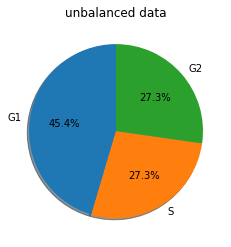

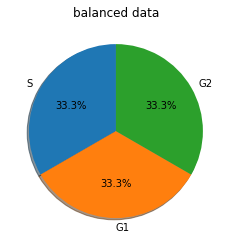

In [14]:
merged_df=preprocess_df(df=pd.read_csv("/content/Ground_truth.lst",header=None),
                        save_path="cell_merged.csv")

df_m=pd.read_csv("cell_merged.csv")
plot_dict_pie(df_m, "class_name", "unbalanced data")

balanced_df=balance_df(df_m, "class_name")
plot_dict_pie(balanced_df, "class_name", "balanced data")
balanced_df.to_csv("cell_merged_balanced.csv")

create_subset(input_csv_path="/content/cell_merged_balanced.csv",
              output_csv_path="cell_merged_subset.csv",
              lower_lim=0,
              upper_lim=29000)

create_folds_from_csv(input_csv_path='/content/cell_merged_subset.csv',
                      output_csv_path='./train_targets_folds.csv')

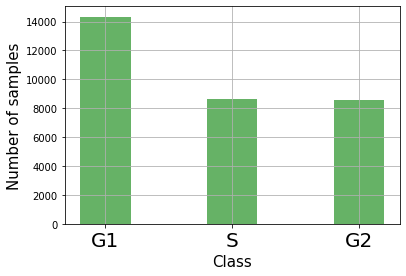

In [32]:
class_list=list(df_m['class_name'].value_counts())
width = 0.40
labels=['G1', 'S', 'G2']
ind = np.arange(3)
plt.bar(ind, class_list, width, label="Current Devolearn model", color='green', alpha=0.6)
plt.xticks(ind, labels, fontsize=20)
plt.ylabel('Number of samples', fontsize=15)
plt.xlabel("Class", fontsize=15)
plt.grid()


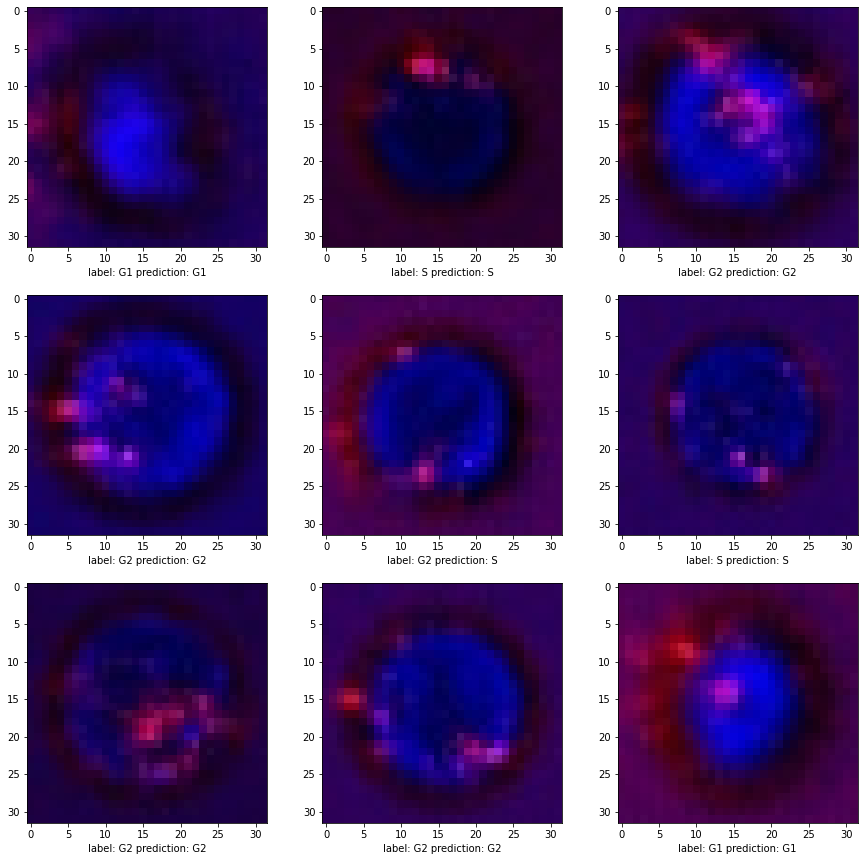

In [ ]:
fig, ax = plt.subplots(3,3, figsize = (15,15))
torch.cuda.empty_cache()
class_dict={'G1':0,
            'S': 1,
            'G2':2}

for i in range (9):
  data = next(iter(dl_holdout))
  image, label = data['x'], data['y']
  #print(label)
  #image[0]=np.clip(image[0], 0, 1)
  ax.flat[i].imshow(image[0].permute(1,2,0))

  #batch_output=model(image.to(device))
  batch_output=model_jury(all_models,image.to(device))
  _,batch_prediction=torch.max(batch_output.data, 1)
  image_pred=batch_prediction[0].item()
  
  text = "label: "+list(class_dict.keys())[int(label[0])] +" prediction: "+list(class_dict.keys())[int(image_pred)]
  ax.flat[i].set_xlabel(text)